In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
sys.path.append("..")
from common_functions import HSV_features_generation

In [33]:
def eval_random_forest(X,y,n_estimators,max_depth,k,min_samples_split=2, min_samples_leaf=1,show_forest=False):
    # Initialize lists to store the accuracy scores, features weights and confusion matrix
    accuracy_scores = []
    val_accuracy_scores = []
    test_accuracy_scores = []
    features_weights = []
    confusion_matrixs = []
    val_confusion_matrixs = []
    test_confusion_matrixs = []

    # StratifiedKFold with k folds
    skf = StratifiedKFold(n_splits=k)

    for i, (train_index, val_test_index) in enumerate(skf.split(X, y)):
        if(show_forest):
            print(f"Fold {i}:")
        #Train dataset
        X_train = X.iloc[train_index]
        y_train = y[train_index]

        #Validation and test dataset
        skf2 = StratifiedKFold(n_splits=2)
        test_index,val_index = next(skf2.split(X.iloc[val_test_index], y[val_test_index]))
        X_val = X.iloc[val_test_index].iloc[val_index]
        y_val = y[val_test_index][val_index]
        X_test = X.iloc[val_test_index].iloc[test_index]
        y_test = y[val_test_index][test_index]

        #Random forest init
        random_forest = RandomForestClassifier(random_state=0,n_estimators=n_estimators, max_depth=max_depth,min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        
        #Random forest train
        random_forest.fit(X_train, y_train)

        #Predictions
        y_train_pred = random_forest.predict(X_train)
        y_val_pred = random_forest.predict(X_val)
        y_test_pred = random_forest.predict(X_test)

        #Accuracy score
        accuracy = metrics.accuracy_score(y_train, y_train_pred)
        val_accuracy = metrics.accuracy_score(y_val, y_val_pred)
        test_accuracy = metrics.accuracy_score(y_test, y_test_pred)

        #confusion matrix
        confusion_mat = confusion_matrix(y_train, y_train_pred)
        confusion_mat_val = confusion_matrix(y_val, y_val_pred)
        confusion_mat_test= confusion_matrix(y_test, y_test_pred)

        if(show_forest):
            print(f'Fold {i} accuracy : {accuracy}, val accuracy :{val_accuracy}')

        # Append the accuracy score to the list
        accuracy_scores.append(accuracy)
        val_accuracy_scores.append(val_accuracy)
        test_accuracy_scores.append(test_accuracy)
        features_weights.append(random_forest.feature_importances_) 
        confusion_matrixs.append(confusion_mat)
        val_confusion_matrixs.append(confusion_mat_val)
        test_confusion_matrixs.append(confusion_mat_test)
        
        #Print features weights
        if(show_forest):
            print(f"Poids caractéristiques : {random_forest.feature_importances_}")

    # Compute the average accuracy across all folds
    if(show_forest):
        print('-------------------')
        print(f"Train accuracy : {np.mean(accuracy_scores)}")
        print(f"Val accuracy : {np.mean(val_accuracy_scores)}")
        print(f"Test accuracy : {np.mean(test_accuracy_scores)}")
    features_weights = np.array(features_weights)
    average_weights = [features_weights[:,i].mean() for i in range(6)]
    if(show_forest):
        print('Average feature weights',average_weights)

    # Filter weights to not show null values
    filtered_weights = [w for w in average_weights if w != 0]
    filtered_feature_names = [name for name, w in zip(['H_mean','H_std','S_mean','S_std','V_mean','V_std'], average_weights) if w != 0]

    if(show_forest):
        plt.pie(filtered_weights, labels=filtered_feature_names, autopct='%1.1f%%')
        plt.show()

        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_xlabel('Prédiction')
        ax.set_ylabel('Vraie étiquette')
        ax.set_title('Matrice de confusion')
        print('Average confusion matrix')
        sns.heatmap(np.mean(confusion_matrixs, axis=0), annot=True, cmap="Blues", ax=ax, fmt='.0f')
        plt.show()

        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_xlabel('Prédiction')
        ax.set_ylabel('Vraie étiquette')
        ax.set_title('Matrice de confusion val')
        print('Average val confusion matrix')
        sns.heatmap(np.mean(val_confusion_matrixs, axis=0), annot=True, cmap="Oranges", ax=ax, fmt='.0f')
        plt.show()

        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_xlabel('Prédiction')
        ax.set_ylabel('Vraie étiquette')
        ax.set_title('Matrice de confusion test')
        print('Average test confusion matrix')
        sns.heatmap(np.mean(test_confusion_matrixs, axis=0), annot=True, cmap="Greens", ax=ax, fmt='.0f')
        plt.show()

    return np.mean(accuracy_scores),np.mean(val_accuracy_scores),np.mean(test_accuracy_scores),np.array(average_weights)



In [82]:
#raw
X,y = HSV_features_generation('../images/roi_pollub/')


In [85]:
#Test max_depth fixe, variation test_estimators et k
k = 4
acc_train = []
acc_val = []
acc_test = []
test_estimators = [50,100,150,200,250,300,350,400,450,500]

for nb_estimators in test_estimators:
    accuracies = []
    val_accuracies = []
    test_accuracies = []
    for max_depth in range(2,6+1):
        accuracy,val_accuracy,test_accuracy,features_weights = eval_random_forest(X,y,nb_estimators,max_depth,k)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
    acc_train.append(accuracies)
    acc_val.append(val_accuracies)
    acc_test.append(test_accuracies)


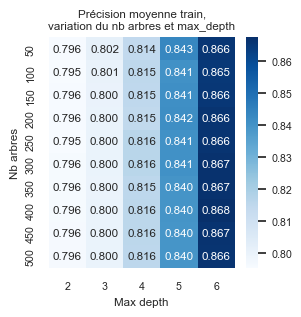

In [86]:
sns.set(font_scale=0.7)
mat_acc_train = np.array(acc_train)
labels_x = range(2,6+1)
labels_y = test_estimators
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_train, annot=True, cmap="Blues", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('Max depth')
plt.ylabel('Nb arbres')
plt.title('Précision moyenne train,\nvariation du nb arbres et max_depth')
plt.show()

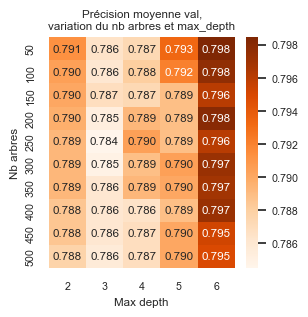

In [87]:
mat_acc_val = np.array(acc_val)
labels_x = range(2,6+1)
labels_y = test_estimators
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_val, annot=True, cmap="Oranges", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('Max depth')
plt.ylabel('Nb arbres')
plt.title('Précision moyenne val,\nvariation du nb arbres et max_depth')
plt.show()

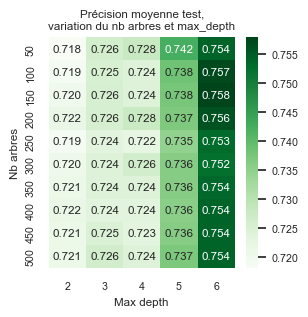

In [88]:
mat_acc_test = np.array(acc_test)
labels_x = range(2,6+1)
labels_y = test_estimators
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_test, annot=True, cmap="Greens", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('Max depth')
plt.ylabel('Nb arbres')
plt.title('Précision moyenne test,\nvariation du nb arbres et max_depth')
plt.show()

In [90]:
acc_train = []
acc_val = []
acc_test = []
k = 4
nb_estimators =100
max_depth = 6
for min_samples_split in range(2,20+1,5):
    accuracies = []
    val_accuracies = []
    test_accuracies = []
    for min_samples_leaf in range(1,20+1,5):
        accuracy,val_accuracy,test_accuracy,features_weights = eval_random_forest(X,y,nb_estimators,max_depth,k,min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
    acc_train.append(accuracies)
    acc_val.append(val_accuracies)
    acc_test.append(test_accuracies)

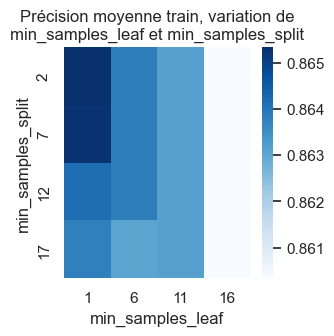

In [91]:
sns.set(font_scale=1)
mat_acc_train = np.array(acc_train)
labels_x = range(1,20+1,5)
labels_y = range(2,20+1,5)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_train,cmap="Blues", xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('min_samples_leaf')
plt.ylabel('min_samples_split')
plt.title('Précision moyenne train, variation de\nmin_samples_leaf et min_samples_split')
plt.show()

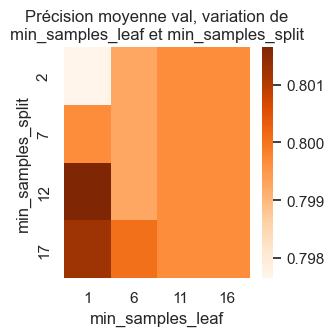

In [92]:
mat_acc_val = np.array(acc_val)
labels_x = range(1,20+1,5)
labels_y = range(2,20+1,5)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_val, cmap="Oranges", xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('min_samples_leaf')
plt.ylabel('min_samples_split')
plt.title('Précision moyenne val, variation de\nmin_samples_leaf et min_samples_split')
plt.show()

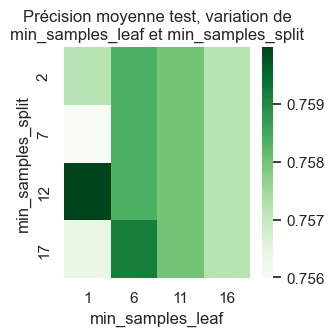

In [93]:
mat_acc_test = np.array(acc_test)
labels_x = range(1,20+1,5)
labels_y = range(2,20+1,5)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_test,cmap="Greens", xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('min_samples_leaf')
plt.ylabel('min_samples_split')
plt.title('Précision moyenne test, variation de\nmin_samples_leaf et min_samples_split')
plt.show()